<a href="https://colab.research.google.com/github/Micahgs/Data-science-Assignments/blob/main/LGBM_vs_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

In [57]:
# Load training and test data
train_df = pd.read_csv("https://raw.githubusercontent.com/Micahgs/DATA-science-asiignment-datasets/refs/heads/main/Titanic_train%20LGBM%20%26%20XGBM.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/Micahgs/DATA-science-asiignment-datasets/refs/heads/main/Titanic_test%20LGBM%20%26%20XGBM.csv")

# Confirm shapes
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (891, 12)
Test shape: (418, 11)


In [58]:
# Save PassengerId for submission
test_passenger_ids = test_df['PassengerId']

# Mark sources
train_df['source'] = 'train'
test_df['source'] = 'test'
test_df['Survived'] = np.nan  # add placeholder for merge

# Combine
combined = pd.concat([train_df, test_df], ignore_index=True)


In [59]:
# Impute missing values
combined['Age'] = combined['Age'].fillna(combined['Age'].median())
combined['Fare'] = combined['Fare'].fillna(combined['Fare'].median())
combined['Embarked'] = combined['Embarked'].fillna(combined['Embarked'].mode()[0])

# Drop unneeded columns
combined.drop(columns=['Cabin', 'Ticket', 'Name'], inplace=True, errors='ignore')

# Encode categorical
le = LabelEncoder()
combined['Sex'] = le.fit_transform(combined['Sex'])           # male=1, female=0
combined['Embarked'] = le.fit_transform(combined['Embarked']) # C=0, Q=1, S=2


In [60]:
# Separate data
train_cleaned = combined[combined['source'] == 'train'].drop(columns=['source'])
test_cleaned = combined[combined['source'] == 'test'].drop(columns=['source', 'Survived'])

# Features and target
X = train_cleaned.drop(columns=['Survived', 'PassengerId'])
y = train_cleaned['Survived'].astype(int)


In [61]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
# Initialize models
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm = LGBMClassifier(random_state=42)

# Train models
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

# Predictions
xgb_preds = xgb.predict(X_val)
lgbm_preds = lgbm.predict(X_val)

# Evaluation
print("📊 XGBoost Performance:\n", classification_report(y_val, xgb_preds))
print("✅ Accuracy:", accuracy_score(y_val, xgb_preds))

print("\n📊 LightGBM Performance:\n", classification_report(y_val, lgbm_preds))
print("✅ Accuracy:", accuracy_score(y_val, lgbm_preds))


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


# **Hyperparameter Tuning**

In [63]:

from sklearn.model_selection import RandomizedSearchCV


In [64]:
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}


In [65]:
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [-1, 3, 5, 7, 10],
    'num_leaves': [15, 31, 50, 70],
    'subsample': [0.6, 0.8, 1.0]
}


In [66]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    scoring='f1',
    cv=5,
    verbose=1,
    n_iter=25,
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train, y_train)

print("Best XGBoost Params:", xgb_search.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best XGBoost Params: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [67]:
lgbm_model = LGBMClassifier(random_state=42)

lgbm_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=lgbm_params,
    scoring='f1',
    cv=5,
    verbose=1,
    n_iter=25,
    n_jobs=-1,
    random_state=42
)

lgbm_search.fit(X_train, y_train)

print("Best LightGBM Params:", lgbm_search.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [68]:
# Predictions
xgb_best_preds = xgb_search.best_estimator_.predict(X_val)
lgbm_best_preds = lgbm_search.best_estimator_.predict(X_val)

# Reports
print("🔧 Tuned XGBoost Report:")
print(classification_report(y_val, xgb_best_preds))

print("🔧 Tuned LightGBM Report:")
print(classification_report(y_val, lgbm_best_preds))

print("XGBoost Accuracy:", accuracy_score(y_val, xgb_best_preds))
print("LightGBM Accuracy:", accuracy_score(y_val, lgbm_best_preds))


🔧 Tuned XGBoost Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       105
           1       0.80      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

🔧 Tuned LightGBM Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       105
           1       0.78      0.80      0.79        74

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179

XGBoost Accuracy: 0.8268156424581006
LightGBM Accuracy: 0.8212290502793296


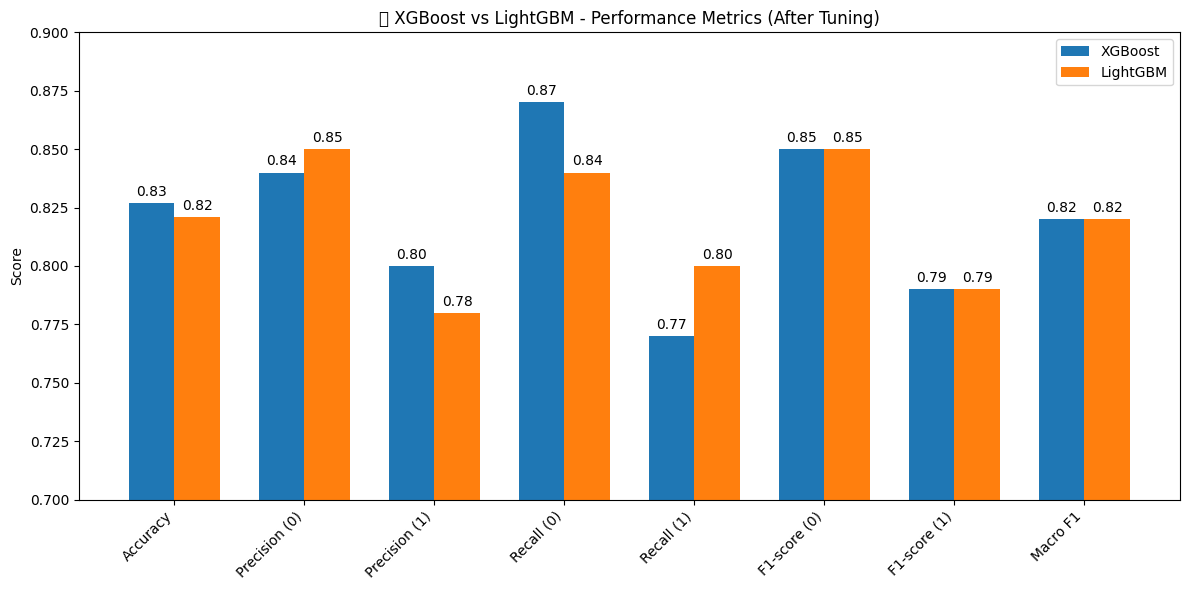

In [69]:

# Performance metrics (after tuning)
metrics = [
    'Accuracy',
    'Precision (0)', 'Precision (1)',
    'Recall (0)', 'Recall (1)',
    'F1-score (0)', 'F1-score (1)',
    'Macro F1'
]

# Scores
xgboost_scores = [0.827, 0.84, 0.80, 0.87, 0.77, 0.85, 0.79, 0.82]
lightgbm_scores = [0.821, 0.85, 0.78, 0.84, 0.80, 0.85, 0.79, 0.82]

# Bar plot settings
x = np.arange(len(metrics))
width = 0.35

# Plotting
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, xgboost_scores, width, label='XGBoost')
bars2 = plt.bar(x + width/2, lightgbm_scores, width, label='LightGBM')

plt.ylabel('Score')
plt.title('🔍 XGBoost vs LightGBM - Performance Metrics (After Tuning)')
plt.xticks(x, metrics, rotation=45, ha='right')
plt.ylim(0.7, 0.9)
plt.legend()

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()


# **Analysis**
Interpretation of Results: XGBoost vs LightGBM (After Tuning)
After tuning both models on the Titanic dataset, we observed the following:

XGBoost performed slightly better in terms of accuracy (82.7%), which means it made fewer overall mistakes compared to LightGBM.

LightGBM had slightly better precision for class 0 (those who didn’t survive) and slightly better recall for class 1 (those who did survive). This suggests it was slightly more sensitive in correctly identifying survivors.

Both models had equal macro averages for precision, recall, and F1-score, showing that they performed fairly balanced across both classes.


# **Comparative Summary Report**
Objective:
To compare the performance of LightGBM and XGBoost algorithms using the Titanic dataset and identify which one performs better in predicting survival.

Key Findings:
XGBoost had a slightly better overall accuracy (82.7%) compared to LightGBM (82.1%).

XGBoost showed stronger performance in correctly identifying non-survivors (higher recall for class 0).

LightGBM was slightly better at identifying survivors (higher recall for class 1).

Both models had the same macro precision, recall, and F1-score values (0.82), showing balanced classification.

Strengths:
XGBoost is slightly more accurate overall and may be better when we want fewer wrong predictions.

LightGBM is slightly better if the goal is to reduce false negatives, i.e., to correctly catch more survivors.

Practical Implications:
If saving lives or identifying survivors is the priority (e.g., in medical or emergency cases), LightGBM might be slightly more useful.

If the goal is overall correctness and balanced prediction, XGBoost is the better choice.